In [5]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
# Load strategy data and calculate daily returns
trade_data = pd.read_csv('trade_history_nq.csv', parse_dates=['Exit time'])
daily_pnl = trade_data.groupby(trade_data['Exit time'].dt.floor('D'))['Profit'].sum()
daily_returns = daily_pnl.cumsum().add(100000).pct_change().dropna()

# Ensure daily_returns is 1-dimensional
daily_returns = daily_returns.squeeze() if isinstance(daily_returns, pd.DataFrame) else daily_returns

# Download benchmark data (S&P 500) and calculate returns
benchmark_data = yf.download('^SPX', start=daily_returns.index.min(), end=daily_returns.index.max(), auto_adjust=True)
benchmark_returns = benchmark_data['Close'].pct_change().dropna()

# Align benchmark returns with strategy dates
benchmark_prices = (1 + benchmark_returns).cumprod()
daily_range = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq='D')
benchmark_aligned = benchmark_prices.reindex(daily_range, method='bfill').reindex(daily_returns.index)
benchmark_aligned_returns = benchmark_aligned.pct_change(fill_method=None).fillna(0)

# Ensure benchmark_aligned_returns is 1-dimensional
benchmark_aligned_returns = benchmark_aligned_returns.squeeze() if isinstance(benchmark_aligned_returns, pd.DataFrame) else benchmark_aligned_returns

# Combine strategy and benchmark returns into a DataFrame
aligned_df = pd.DataFrame({'strategy': daily_returns, 'benchmark': benchmark_aligned_returns}).dropna()

print(aligned_df.head())

[*********************100%***********************]  1 of 1 completed

            strategy  benchmark
Exit time                      
2017-01-05  0.011479   0.000000
2017-01-06 -0.003584   0.000000
2017-01-09  0.008974  -0.003549
2017-01-10  0.001508   0.000000
2017-01-11 -0.014326   0.002830


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:               strategy   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     88.62
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           2.39e-20
Time:                        15:40:38   Log-Likelihood:                 2220.3
No. Observations:                1194   AIC:                            -4437.
Df Residuals:                    1192   BIC:                            -4426.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0

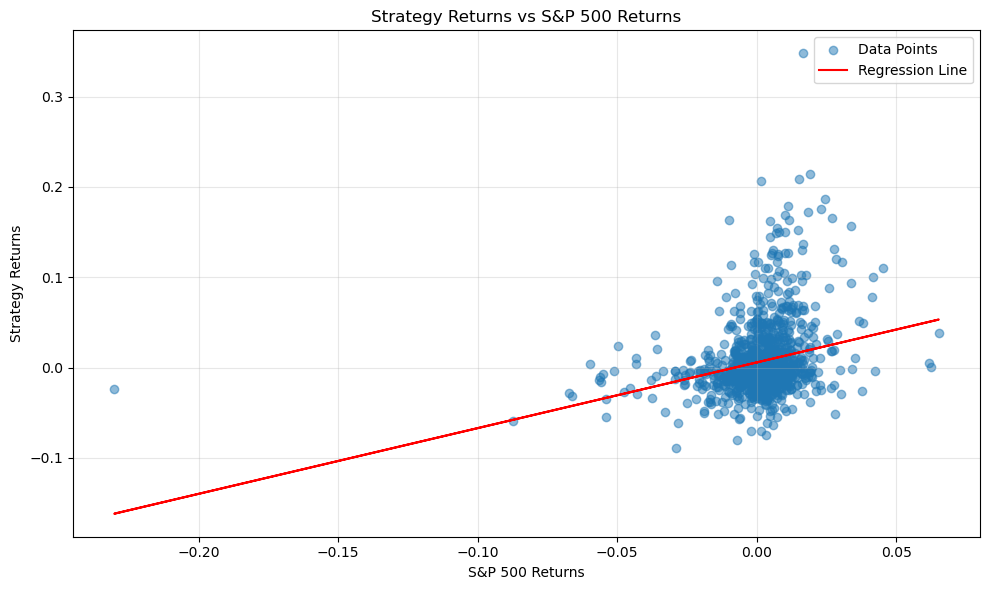

In [7]:
# Add a constant to the benchmark returns for OLS (to calculate alpha)
X = sm.add_constant(aligned_df['benchmark'])  # Independent variable (benchmark returns)
y = aligned_df['strategy']  # Dependent variable (strategy returns)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Extract metrics
alpha = results.params['const']
beta = results.params['benchmark']
r_squared = results.rsquared
correlation = aligned_df['strategy'].corr(aligned_df['benchmark'])

# Print model summary
print("OLS Regression Results:")
print(results.summary())
print(f"\nAlpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Correlation: {correlation:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(aligned_df['benchmark'], aligned_df['strategy'], alpha=0.5, label='Data Points')
plt.plot(aligned_df['benchmark'], results.fittedvalues, color='red', label='Regression Line')

plt.title('Strategy Returns vs S&P 500 Returns')
plt.xlabel('S&P 500 Returns')
plt.ylabel('Strategy Returns')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Monthly Returns Preview:
         strategy  benchmark
month                       
2017-01  0.058175   0.001801
2017-02 -0.030163   0.035756
2017-03 -0.040081  -0.000082
2017-04  0.061053   0.009237
2017-05  0.070354   0.011602


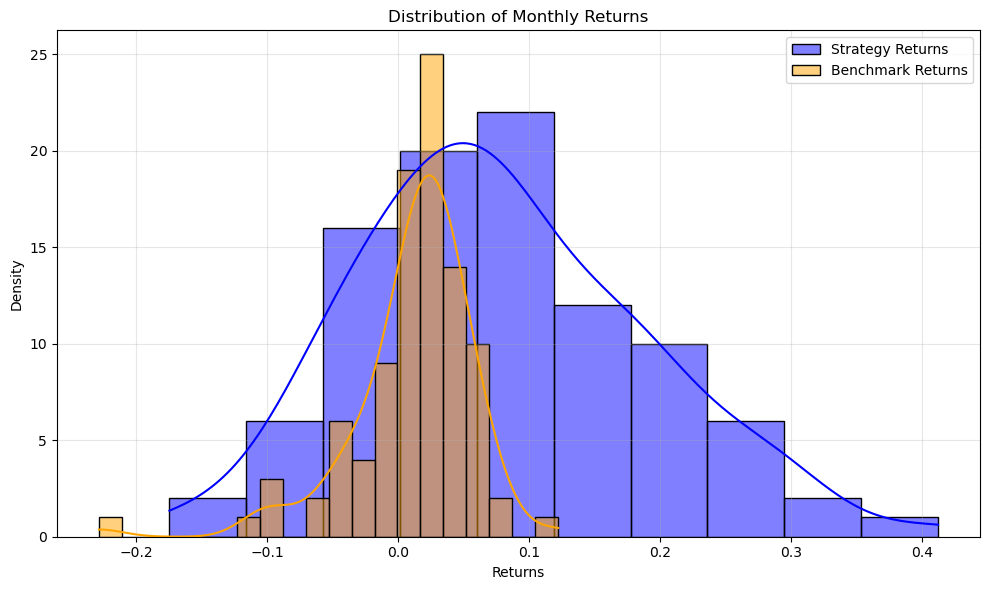

In [ ]:
# Calculate monthly returns for strategy and benchmark
aligned_df['month'] = aligned_df.index.to_period('M')
monthly_returns = aligned_df.groupby('month')[['strategy', 'benchmark']].sum()

# Print preview of monthly returns
print("Monthly Returns Preview:")
print(monthly_returns.head())

plt.figure(figsize=(10, 6))
sns.histplot(monthly_returns['strategy'], kde=True, label='Strategy Returns', color='blue')
sns.histplot(monthly_returns['benchmark'], kde=True, label='Benchmark Returns', color='orange')
plt.title('Distribution of Monthly Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Joe D\AppData\Local\Temp\ipykernel_25964\588247662.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = aligned_df['strategy'].resample('M').apply(lambda x: (x + 1).prod() - 1)


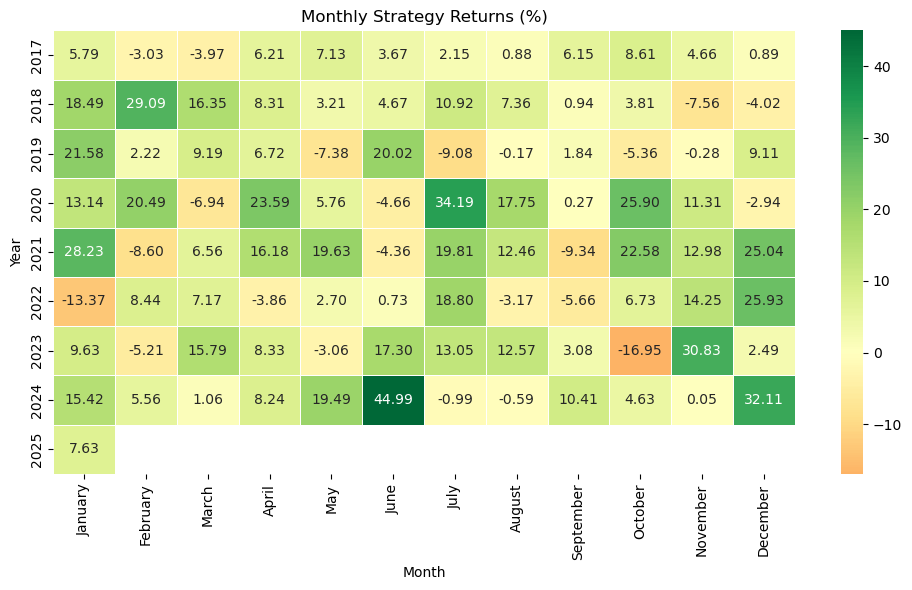

In [9]:
# Calculate monthly returns for the strategy
monthly_returns = aligned_df['strategy'].resample('M').apply(lambda x: (x + 1).prod() - 1)
monthly_returns = monthly_returns * 100

# Extract year and month from the index
monthly_returns = monthly_returns.to_frame(name='Return')
monthly_returns['Year'] = monthly_returns.index.year
monthly_returns['Month'] = monthly_returns.index.month_name()

# Pivot the DataFrame for the heatmap
heatmap_data = monthly_returns.pivot(index='Year', columns='Month', values='Return')

# Reorder columns to match calendar months
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
heatmap_data = heatmap_data.reindex(columns=month_order)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='RdYlGn', center=0, linewidths=0.5)
plt.title('Monthly Strategy Returns (%)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

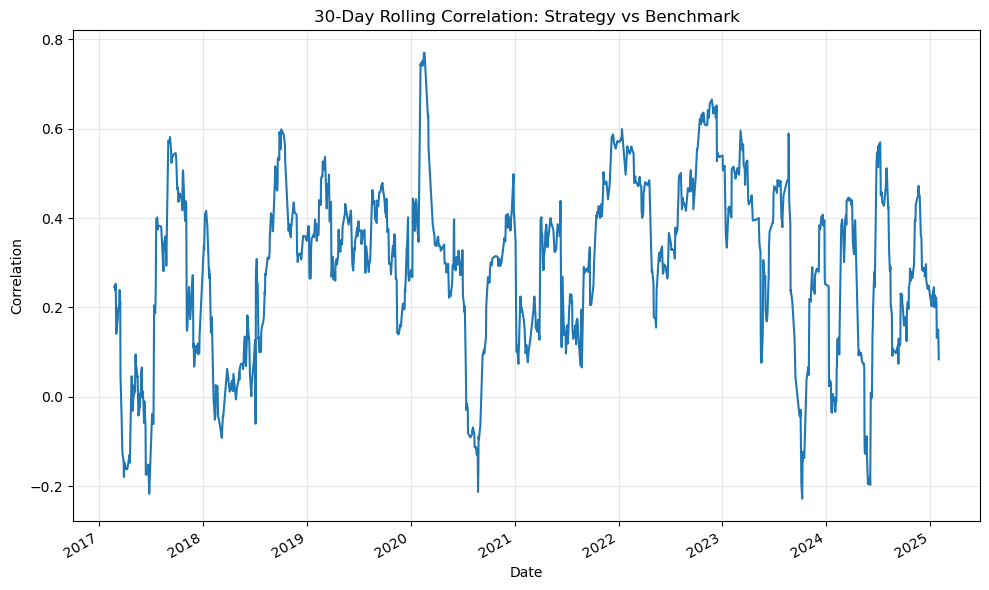

In [10]:
# Rolling correlation
rolling_corr = aligned_df['strategy'].rolling(window=30).corr(aligned_df['benchmark'])

plt.figure(figsize=(10, 6))
rolling_corr.plot()
plt.title('30-Day Rolling Correlation: Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

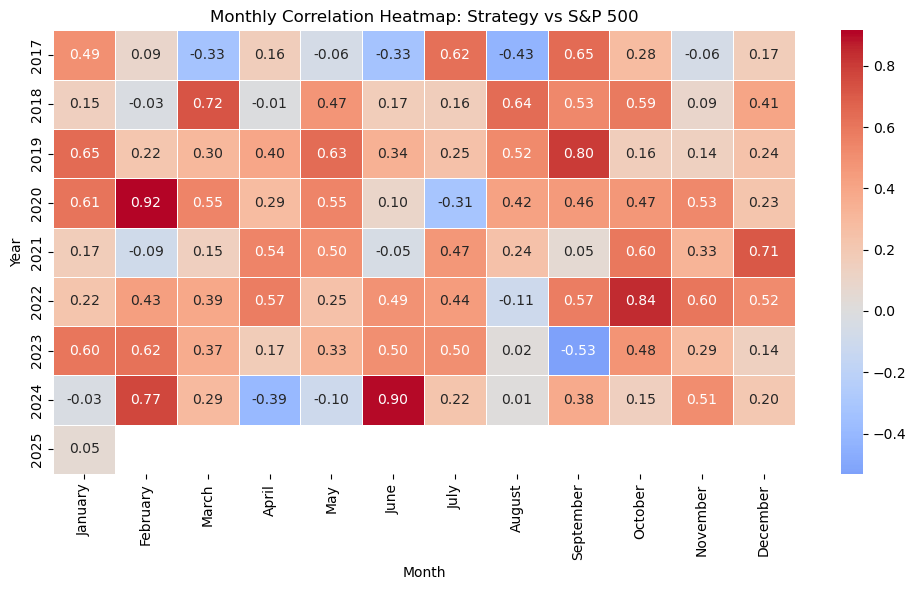

In [ ]:
# Create month and year columns
aligned_df['Year'] = aligned_df.index.year
aligned_df['Month'] = aligned_df.index.month_name()

# Sort correlation matrix
years = sorted(aligned_df['Year'].unique())
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
corr_matrix = pd.DataFrame(index=years, columns=month_order)

# Calculate correlation for each year-month combination
for year in years:
    for month in month_order:
        # Get data for this specific year and month
        year_month_data = aligned_df[(aligned_df['Year'] == year) & (aligned_df['Month'] == month)]
        
        # Check if we have enough data points
        if len(year_month_data) > 1:
            # Calculate correlation between strategy and benchmark
            corr = year_month_data['strategy'].corr(year_month_data['benchmark'])
            corr_matrix.loc[year, month] = corr
        else:
            # Set to NaN if not enough data
            corr_matrix.loc[year, month] = np.nan

# Convert all values to float
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
            linewidths=0.5, mask=corr_matrix.isna())
plt.title('Monthly Correlation Heatmap: Strategy vs S&P 500')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

Max Leverage: 17.1232
Average Leverage: 5.7856


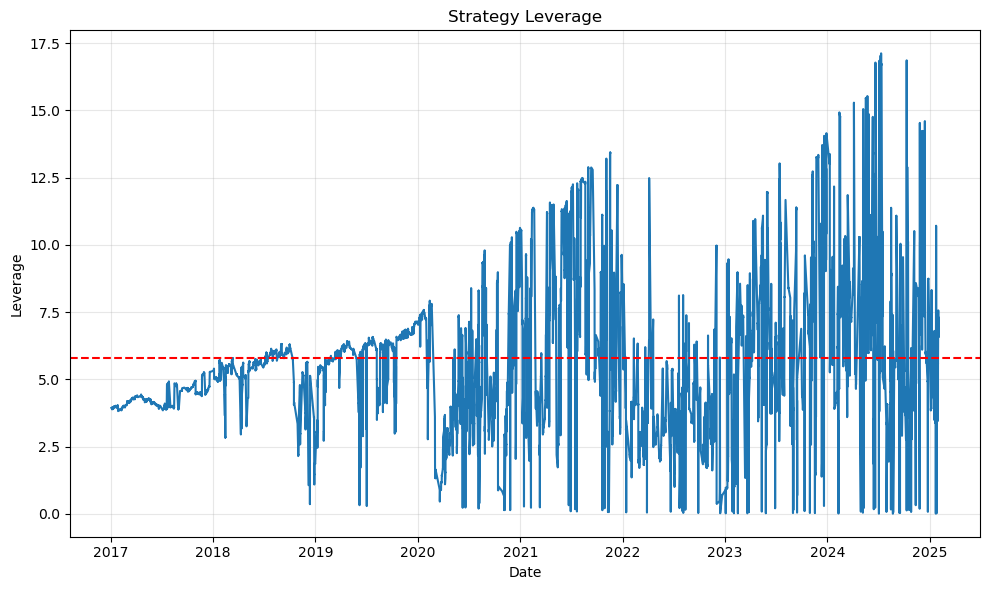

In [15]:
data = pd.read_csv('leverage_history_nq.csv', parse_dates=['Date Time'])

avg_leverage = data['Leverage'].mean()
max_leverage = data['Leverage'].max()
print(f"Max Leverage: {max_leverage:.4f}")
print(f"Average Leverage: {avg_leverage:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(data['Date Time'], data['Leverage'])
plt.axhline(y=avg_leverage, color='r', linestyle='--')
plt.xlabel('Date')
plt.title('Strategy Leverage')
plt.ylabel('Leverage')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()